# Lecture 16 - Advanced Curve Fitting: Multivariate Gaussian Process Regression and Automatic Relevance Determination

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\E}{\mathbf{E}}
$$

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os
import scipy
import scipy.stats as st

import GPy
from GPy.kern import Kern
from GPy.core.parameterization import Param
import pyDOE
from sklearn.utils import shuffle

import wget

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Objectives

+ To demonstrate GP regression with multiple inputs.
+ To highlight how GP regression does automatic relevance determination.
+ To discuss the curse of dimensionality in the context of GP regression and some ways of dealing with it (active subspaces and high-dimensional model representation).

## Readings

+ [Rasmussen Gaussian process textbook](http://www.gaussianprocess.org/gpml/chapters/).
+ [Active subspace paper (Constantine)](https://epubs.siam.org/doi/pdf/10.1137/130916138).

## Multivariate Gaussian Process Regression

When we say "multivariate" here we refer to many function inputs, not outputs.
This just means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
In that regard, nothing really changes compared to one-input GPR.
The formulas are exactly the same.
However, in higher dimensional settings one must pay attention to the selection of the covariance function.

Let's demonstrate this using an example.
Here is an analytical function, known as the Branin-Hoo function:
$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

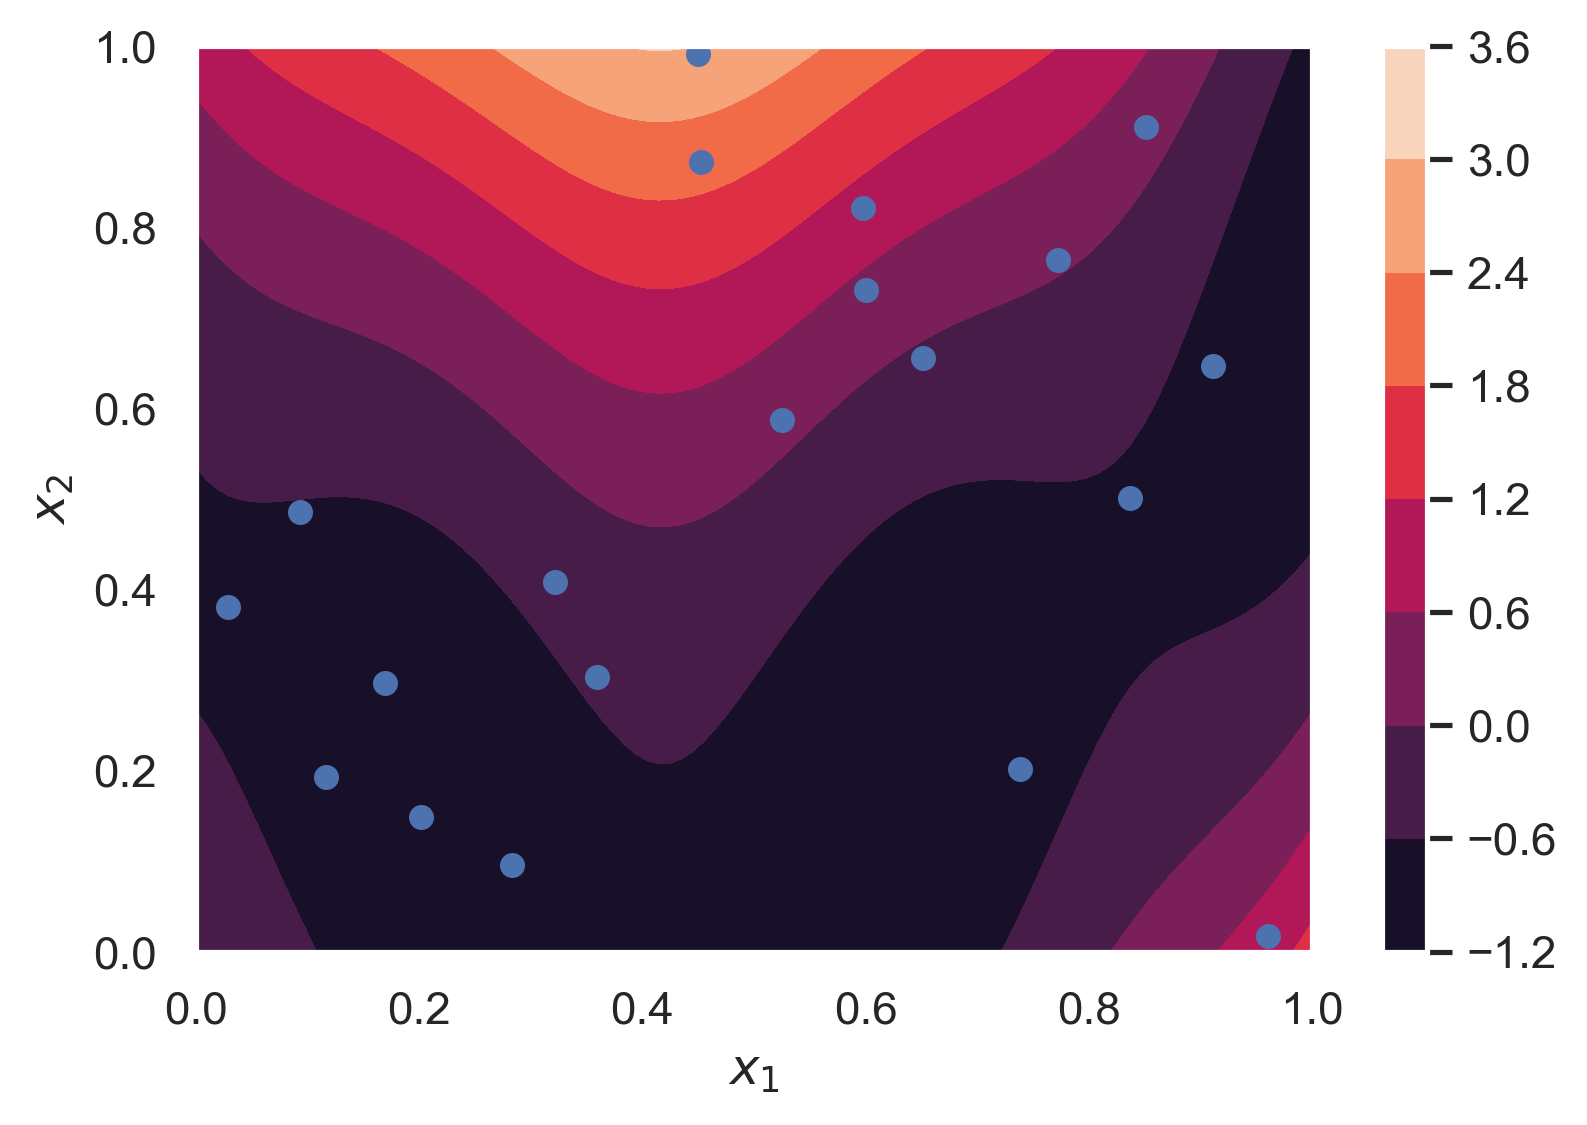

In [2]:
# Define the function
def f_branin(x):
    """
    Input must be 2D array of size N x 2.
    """
    return 1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)

# Generate synthetic data
n = 20
# Always use Latin-hypercube sampling when you get to pick the data
import pyDOE
X = pyDOE.lhs(2, n)
# We will also be adding a little bit of noise to the observations
sigma = 0.01
y = f_branin(X)[:, None] + sigma * np.random.randn(n, 1)

# Plot the contour and the observations
fig, ax = plt.subplots(dpi=300)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_star_flat = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
Z_true = f_branin(X_star_flat).reshape(X1.shape)
c = ax.contourf(X1, X2, Z_true)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
plt.colorbar(c)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

We will be using a the squared exponential covariance function for a regression along with a zero mean.
So our prior GP is:
$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$
with
$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1}-\frac{(x_2-x_2')^2}{2\ell_2}\right).
$$
The first, situation we are going to examin is when the lengthscales are the same:
$$
\ell_1 = \ell_2.
$$
This is what you get by default from ``GPy``:

In [3]:
k = GPy.kern.RBF(2) # The 2 here is for the dimensionality of the input space
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 28.23994383064552
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [4]:
# perform the optimization 
gp.optimize_restarts(robust=True);

Optimization restart 1/10, f = 11.370770381341998
Optimization restart 2/10, f = 11.37077038132401
Optimization restart 3/10, f = 29.091842393626493
Optimization restart 4/10, f = 11.370770381296115
Optimization restart 5/10, f = 11.370770381297138
Optimization restart 6/10, f = 11.37077038138662
Optimization restart 7/10, f = 11.370770381299678
Optimization restart 8/10, f = 11.370770381295973
Optimization restart 9/10, f = 11.370770381295864
Optimization restart 10/10, f = 11.370770381423332


In [5]:
# print out the model details 
print(gp)


Name : GP regression
Objective : 11.370770381295864
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    1.6326178058142786  |      +ve      |        
  rbf.lengthscale          |    0.3056283868697305  |      +ve      |        
  Gaussian_noise.variance  |  0.006905865196706805  |      +ve      |        


In [6]:
# check the lengthscale 
print(gp.kern.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.30562839  |      +ve      |        


Text(0, 0.5, '$x_2$')

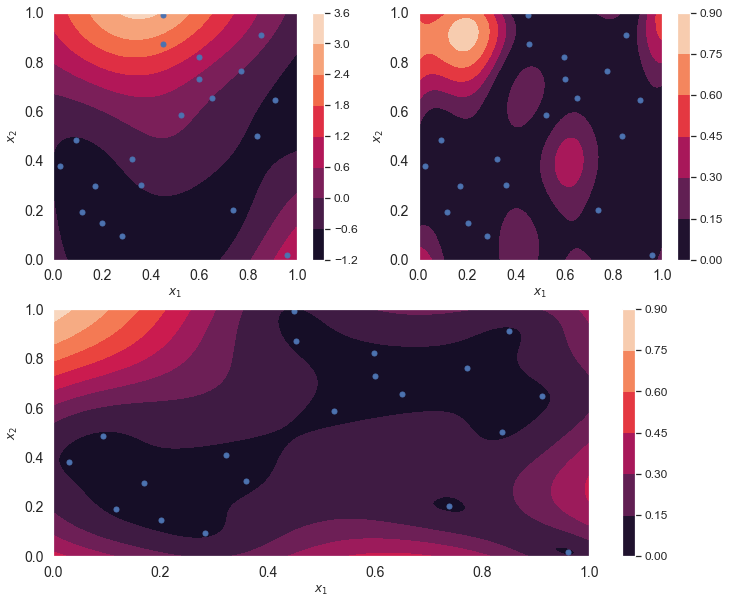

In [7]:
# Make predictions
z_flat, v_flat = gp.predict(X_star_flat)

# start a new figure
fig = plt.figure(figsize=(12, 10))

#plot the contour of the predictions (Compare to contour of true values above)
ax = plt.subplot(221)
ax.tick_params(axis='both', labelsize=14)
Z_star = z_flat[:, 0].reshape(X1.shape)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
im = ax.contourf(X1, X2, Z_star)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

# Let's also plot the contour of the error
ax = plt.subplot(222)
ax.tick_params(axis='both', labelsize=14)
E = np.abs(Z_true - Z_star)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
im = ax.contourf(X1, X2, E)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

# And let's compare the error plot to 2 x the predictive standard deviation
ax = plt.subplot(212)
ax.tick_params(axis='both', labelsize=14)
ax.plot(X[:, 0], X[:, 1], 'bo', markersize=5)
c = ax.contourf(X1, X2, 2.0 * np.sqrt(v_flat.reshape(X1.shape)))
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [8]:
k = GPy.kern.RBF(2, ARD=True) # The ARD = True is what makes GPy understand that there is
                              # one lengthscale per dimension
gp = GPy.models.GPRegression(X, y, k)
print(gp)


Name : GP regression
Objective : 28.23994383064552
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that you now cannot see what the lengthscale values are.
You need to do this to see them:

In [9]:
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.00000000  |      +ve      |        
  [1]    |                     1.00000000  |      +ve      |        


And you can train the model as usual:

In [10]:
gp.optimize_restarts(); # No messages shown here
print(gp)
print(gp.rbf.lengthscale)

Optimization restart 1/10, f = 4.325465081062454
Optimization restart 2/10, f = 4.32546508101446
Optimization restart 3/10, f = 4.325467923996621
Optimization restart 4/10, f = 4.325465502183649
Optimization restart 5/10, f = 4.325465110187595
Optimization restart 6/10, f = 4.325471143065606
Optimization restart 7/10, f = 4.325465081165966
Optimization restart 8/10, f = 4.32546626000839
Optimization restart 9/10, f = 4.3254773442536365
Optimization restart 10/10, f = 4.3254650858256944

Name : GP regression
Objective : 4.32546508101446
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     11.032828519119288  |      +ve      |        
  rbf.lengthscale          |                   (2,)  |      +ve      |        
  Gaussian_noise.variance  |  1.243080400653353e-16  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constr

So, you se that the lengthscale assigned to $x_1$ is slightly bigger than the lengthscale assigned to $x_2$. This means that the first input is slightly more important than the second input.
This is the automatic relevance determination (ARD) in action.

Let's add a third dimension to the Branin function, $x_3$, such that $f$ has a weak linear dependence on $x_3$. 

The added term is highlighted in blue.

$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [11]:
# Define the function
def f_branin_1(x):
    """
    Input must be 2D array of size N x 2.
    """
    return (1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)) + (0.1*x[:, 2])

Let's generate some synthetic data and train a GP model with ARD. Let's see if we can discover the weak dependence of $f$ on the newly added 3rd dimension. 

In [12]:
# Generate synthetic data
N    = 40
ndim = 3
X = pyDOE.lhs(ndim, N)

# We will also be adding a little bit of noise to the observations
sigma = 0.01
Y = f_branin_1(X)[:, None] + sigma * np.random.randn(N, 1)

k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(X, Y, k)
print(gp)


Name : GP regression
Objective : 50.27600416641607
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (3,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [13]:
# train the GP
gp.optimize_restarts(10, robust=True); # No messages shown here
print(gp.rbf.lengthscale)

Optimization restart 1/10, f = -22.72200122697501
Optimization restart 2/10, f = -22.722001497086403
Optimization restart 3/10, f = -22.722001255621713
Optimization restart 4/10, f = -22.722001256455215
Optimization restart 5/10, f = -32.55979998002445
Optimization restart 6/10, f = -32.559799972457796
Optimization restart 7/10, f = -22.72200125390232
Optimization restart 8/10, f = -32.55979997039546
Optimization restart 9/10, f = -32.55979995900519
Optimization restart 10/10, f = -22.722001256994268
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.28681344  |      +ve      |        
  [1]    |                     1.61562557  |      +ve      |        
  [2]    |                    82.72200150  |      +ve      |        


Notice from the results above that the lengthscale in the 3rd dimension is very large relative to the lengthscales along the 1st and 2nd dimensions. 
This means that our trained GP model depends very weakly on $x_3$. Clearly, we are able to capture the weak dependence of $f$ on $x_3$. 

Now let's add a fourth dimension to the Branin function, $x_4$, such that $f(x_1, x_2, x_3, x_4) = f(x_1, x_2, x_3)$, i.e., $f$ does not actually depend on $x_4$. 


$$
f(\mathbf{x}) = f(x_1,x_2, x_3, x_4) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [14]:
# define the function
def f_branin_2(x):
    assert x.shape[1] == 4, 'The input should be 4 dimensional.'
    return f_branin_1(x[:, :3])

In [15]:
# Generate synthetic data
N    = 40
ndim = 4
X = pyDOE.lhs(ndim, N)

# We will also be adding a little bit of noise to the observations
sigma = 0.01
Y = f_branin_2(X)[:, None] + sigma * np.random.randn(N, 1)

k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(X, Y, k)
print(gp)


Name : GP regression
Objective : 51.007439920662314
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (4,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [16]:
# train the GP
gp.optimize_restarts(20, robust=True); # No messages shown here
print(gp.rbf.lengthscale)

Optimization restart 1/20, f = -26.73677558629153
Optimization restart 2/20, f = -26.73677558213396
Optimization restart 3/20, f = -26.736775580203954
Optimization restart 4/20, f = -26.736775586593225
Optimization restart 5/20, f = -26.736775587180347
Optimization restart 6/20, f = -26.736775586608132
Optimization restart 7/20, f = -26.736775585888736
Optimization restart 8/20, f = -26.736775584241073
Optimization restart 9/20, f = -26.736775585162704
Optimization restart 10/20, f = -26.736775585603368
Optimization restart 11/20, f = -26.736775493023472
Optimization restart 12/20, f = -26.736775565317885
Optimization restart 13/20, f = -26.73677558667724
Optimization restart 14/20, f = -26.73677558555073
Optimization restart 15/20, f = -26.736775586596636
Optimization restart 16/20, f = -26.736775513024796
Optimization restart 17/20, f = -26.736775584890793
Optimization restart 18/20, f = -26.7367755857712
Optimization restart 19/20, f = -26.736775586694066
Optimization restart 20/20,

Notice that $\ell_4$ is much larger than $\ell_3$, which itself is much larger than $\ell_1$ and $\ell_2$. 
The ARD training procedure discovers that the dependence of the function $f$ is very weak in the input $x_4$.

#### Questions:

+ What happens to the optimized lengthscales if you add more data? 

(.. add more questions ..)

### Dealing with high input dimensionality 

In theory, the Gaussian process regression modeling approach discussed so far should work regardless of the dimensionality of $\mathbf{x}$. Note that we have imposed no restrictions on the structure of $\mathbf{x}$ - $\mathbf{x}$ could be whatever we want it to be - audio/video/text/pictures/scalars/vectors/tensors etc etc.
The ONLY requirement is that we specify a suitable Mercer kernel, $k(\cdot, \cdot)$.

In practice training models on datasets with high-dimensional inputs and small-to-moderately sized datasets often leads to overfitting. 

To deal with the curse of dimensionality, the most straightforward approach is to perform a *principal component analysis* (PCA) of the input data and fitting your model between the projected inputs and the outputs. The PCA recovers directions in the input that capture most of the variance of the inputs. 

Here, we discuss a different, and more recent, approach to dimensionality reduction - namely the *active subspace*. 

### Active subspace 

Denote the unknown underlying function as $f(\mathbf{x})$, where, $\mathbf{x} \in \mathcal{X} \subset \mathbb{R}^{D}$.
The inputs $\mathbf{x}$ reside in a $D$-dimensional vector space where $D$ is reasonably large (think order of 10 or 100). 
In uncertainty quantification tasks $\mathbf{x}$ represents stochastic input parameters equipped with a suitable probability density $p(\mathbf{x})$.

Assume that we have access to the gradients of the function $\nabla_\x f(\x)$. 

**Main idea**: The key idea of active subspaces is to look for directions in the space of the function gradient that captures maximal variation in the quantity of interest. 

We begin by constructing the following second moment matrix:
$$
C = \int \nabla_\x f(\x) \nabla_\x f(\x)^T p(\x) \mathrm{d}\x.
$$

Since this expectation cannot be evaluated in closed form, we form a Monte Carlo approximation of the matrix $C$:
$$
C \approx \hat{C} = \frac{1}{N} \sum_{i=1}^{M} \nabla_{\x} f(\x^{(i)}) \nabla_{\x} f(\x^{(i)})^T.
$$

The above approximation is constructed by sampling $\x^{(i)}$ from the density $p(\x)$.

Once we have the matrix $\hat{C}$, we compute it's spectral decomposition:
$$
\hat{C} = \mathbf{W} \Lambda \mathbf{W}^T.
$$

Since the matrix $\hat{C}$ is a real, symmetric matrix, the matrix of eigenvectors $\mathbf{W}$ form an orthogonal basis spanning $\mathbb{R}^D$. $\Lambda = \mathrm{diag}()\lambda_1, \lambda_2, \dots, \lambda_D$ is a $D \times D$ diagonal matrix of eigenvalues corresponding to the eigenvectors in $\mathbf{W}$. The eigenvalue $\lambda_i$ quantifies the variation of $f$ along the $i^{th}$ eigenvector, i.e., 
$$
\lambda_i = \int \left(  \mathbf{W}_{:i}^{T} \nabla_\x f(\x)   \right)^2 p(\x)  \mathrm{d}\x
$$

For proof of the above statement refer to [this paper](https://epubs.siam.org/doi/pdf/10.1137/130916138).

Based on the above proposition we partition the matrices $\mathbf{W}$ and $\Lambda$ into:
$$
\mathbf{W} = \left[ \mathbf{W}_1 \ \  \mathbf{W}_2   \right], \Lambda = \left[ \Lambda_1 \ \  \Lambda_2 \right],
$$
where, $\Lambda_1$ represents the first $d$ eigenvalues arranged in descending order, such that the corresponding eigenvectors $\mathbf{W}_1$ represent directions that capture most of the variation of $f$.  

The *active subspace* is defined as the linear subspace spanned by the columns of the matrix $W_1$.
Since $\W$ is orthogonal, 
any $\x \in \R^D$ can be written as $\x = \W \W^T \x = (\W_1 \W_{1}^{T} + \W_2 \W_{2}^{T})\x = \W_1 \W_{1}^{T} \x + \W_2 \W_{2}^{T})\x = \W_1\y + \W_2\z$, where, $\y = \W_{1}^{T} \x$ and $\z = \W_{2}^{T} \x$ are called the *active* and *inactive* variables. 

Since the eigenvalues capture the average variation of $f$ with respect to the active and inactive variables, we have:
$ \int \nabla_{\y} f(\x)^T \nabla_\y f(\x) p(\x) \mathrm{d}\x = \sum_{i=1}^{d} \lambda_i$ and $ \int \nabla_{\z} f(\x)^T \nabla_\z f(\x) p(\x) \mathrm{d}\x = \sum_{i=d+1}^{D} \lambda_i$. 

If $\sum_{i=d+1}^{D} \lambda_i$ is small, the function $f(\x)$ may be approximated as:
$$
f(\x) \approx g(\y) =\ g(\W_{1}^{T}\x),
$$
where, $g:\R^d \rightarrow \R$ is a generic $d$-variate function. 


If we have access to the gradient $\nabla_\x f(\cdot)$, and if there exists an exploitable *active subspace*, the task of constructing the $D$-variate function can be simplified into the task of fitting a $d$-variate function where $d \ll D$, thus enabling us to beat the *curse of dimensionality*.

To summarize, our approximation will be of the form:
$$
f(\x) \approx \hat{f}(\x) = g(\y) = g(\W^T \x),
$$
where $\W \in \R^{D \times d}$ is the active subspace projection matrix, such that $\W^T \W = I_{d}$, $I_d$ being the $d \times d$ identity matrix. $g$ is set to be a Gaussian process in $d$ dimensions.

### Active subspace without access to gradients

We discussed in the previous section the notion of an *active subspace* - an expoitable low dimensional structure that is recoverable from information about the gradients of the unknown function $f$. 
If we have access to the gradients and if such an *active subspace* exists, we can circumvent the curse of dimensionality involved in fitting the $D$-variate function, by transforming it into a problem of fitting a $d$-variate function, where, $d \ll D$. 

Unfortunately, in most realistic scenarios, we do not have access to the gradients $\nabla_x f(\cdot)$. In realistic situations, $f$ is a complex, numerical simulator for a physical problem, which, for all practical purposes, has to be treated as a black box - we can sample $\x$s from a probability distribution $p(\x)$ and obtain information about $f$ by running our simulations/experiments at these sample locations, but we cannot realistically expect much else - such as obtain a closed form expression of $\nabla_x f$. 

Can we approximate the gradients? Sure. We could use a basic finite difference scheme to obtain evaluations of $\nabla_x f$ but this incurs a lot of addition computational cost.

Recall, from the previous section, that we are looking for an approximation of the form:
$$
\hat{f}(\x) = g(\W^T \x),
$$
where, $\W$ is a *tall-and-skinny* matrix of orthonormal columns. We do not have access to the gradients $\nabla_\x f$ of the underlying function, but we do have access to a dataset of input-output observations $\mathcal{D} = \{\x^{(i)}, y^{(i)} \}_{i=1}^{N}$.

Instead of learning a Gaussian process regression map between $\x$ and $y$ directly, which is difficult, we will attempt to project the inputs to the active subspace variables $\y = \W^T \x$, by embedding the matrix $\W$ directly into the covariance kernel of the Gaussian process. 

Specifically, we define a covariance kernel of the form:
$$
k(\x, \x') = k_0 (\y, \y') = k_0(\W^T \x, \W^T \x'), 
$$
where, $k_0 (\cdot, \cdot)$ is any standard kernel function. The projection matrix $\W$ is now subsumed into this modified covariance kernel as a new hyperparameter which is learned directly from the available input-output data through the usual process of learning GPR hyperparameters. Particularly, when optimizing the hyperparameters of the kernel through maximum likelihood, the orthonormality constraints of the matrix $\W$ have to be enforced, i.e., we solve the problem:
$$
\W^*, \boldsymbol{\theta}^* = \underset{\boldsymbol{\theta},\W, \text{s.t.} \W^T \W = I_d}{\mathrm{argmax}} \mathcal{L}(\W, \boldsymbol{\theta}; \mathcal{D}).
$$

### A relaxed version of active subspace - ridge functions

The optimization problem posed in the previous section, for learning the active subspace projection directly from input-output data is a challenging problem owing to the need for maintain orthogonality constraints. Various papers in the literature tackle this problem with reasonable success on a variety of applications; see for instance [this](https://www.sciencedirect.com/science/article/pii/S002199911630184X), [this](https://epubs.siam.org/doi/pdf/10.1137/18M1168571) and [this](https://arxiv.org/pdf/1702.05859.pdf) paper.

Here we will relax the orthogonality requirement on $\W$, i.e., we will learn a Gaussian process model with a low-rank covariance kernel of the form:
$$
k(\x, \x') = k_0 (\W^T \x, \W^T \x'),
$$
where, $\W \in \R^{D \times d}$ is an unconstrained tall-and-skinny matrix.

A `GPy` implementation of such a kernel is provided below.

The kernel function $k$, as defined above, puts a prior over the space of functions of the form:
$$
f(\x) = g(\W^T \x).
$$
Such functions are commonly known as *ridge functions*.

In [17]:
class ProjectionKernel(Kern):
    """
    A new kernel created by wrapping around an existing 
    base kernel $k_0$, operating on the space of projectd inputs z=Ax:
    
    k(x, x') = k_0(Ax, Ax').
    
    """
    @property
    def base_kernel(self):
        return self._base_kernel

    def __init__(self, input_dim, base_kernel, name='ProjectionKernel'):
        super(ProjectionKernel, self).__init__(input_dim, None, name)
        lr_dim = base_kernel.input_dim
        assert lr_dim < input_dim, 'The subspace dimension has to be lower than the input dimension.'
        self._base_kernel = base_kernel
        self.A = scipy.linalg.orth(np.random.randn(input_dim, lr_dim))
        self.A = Param('A', self.A)
        self.link_parameters(self.A, self.base_kernel)
    
    def _T(self, X):
        if isinstance(X, np.ndarray):
            return np.dot(X, self.A)
        else:
            return None
    
    def K(self, X, X2=None):
        return self.base_kernel.K(self._T(X), self._T(X2))
    
    def Kdiag(self, X):
        return self.base_kernel.Kdiag(self._T(X))
    
    def update_gradients_full(self, dL_dK, X, X2=None):
        assert X2 is None
        Z = self._T(X)
        self.base_kernel.update_gradients_full(dL_dK, Z)  # this computes the gradient of the loss wrt basekern parameters
        dL_dZ = self.base_kernel.gradients_X(dL_dK, Z)   # this computes the gradient of the loss wrt Z 
        self.A.gradient = np.einsum('ij,ik->kj', dL_dZ, X)  # gradient of the loss wrt projection matrix A

### Constructing ridge function approximation with GPs

We will now demonstrate the application of the above in a simple toy example. Specifically, we will consider a trigonometric function in 2 dimensions with a known ridge function structure:
$$
f(\x) = g(\W^T \x),
$$
where, $g(y) = \sin (2 \pi y)$ is a univariate function, $\W = \left[\frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}} \right] \in \R^{2 \times 1}$ and $\x \sim \mathcal{N}(0, I_2)$.

Note that, *if* an underlying ridge structure exists, attempting to learn the matrix $\W$ through a GP approach is susceptible to arbitrary rescaling of the *active variable* coordinate system.

In [18]:
Wtrue = np.array([1./np.sqrt(2), 1./np.sqrt(2)])[:, None]   # true projection matrix 

# define the underlying function
f = lambda x : np.sin(2. * np.pi * np.dot(x, Wtrue))   # true function in 2 dimensions 


# collect some data and add some noise
N = 20
D = 2
d = 1
noise_var = 0.
X = np.random.randn(N, D)
Y = f(X) 
Y += np.sqrt(noise_var)*np.random.randn(N, 1)

In [19]:
### train a GP model
kbase = GPy.kern.RBF(1)  # define the base kernel
k = ProjectionKernel(D, kbase)  # overall kernel with built-in low rank projection
m = GPy.models.GPRegression(X, Y, k)
_ = m.optimize_restarts(20, robust=True)

Optimization restart 1/20, f = 18.90441671175372
Optimization restart 2/20, f = 18.90441671182225
Optimization restart 3/20, f = 18.904416712012015
Optimization restart 4/20, f = 18.90441671174188
Optimization restart 5/20, f = 18.904416711745416
Optimization restart 6/20, f = 18.904416714215444
Optimization restart 7/20, f = 18.904416711742492
Optimization restart 8/20, f = 18.904416711745256
Optimization restart 9/20, f = 18.904416711743682
Optimization restart 10/20, f = 15.10085236678598
Optimization restart 11/20, f = 18.90441671174715
Optimization restart 12/20, f = 18.90441671184105
Optimization restart 13/20, f = 18.90441671175323
Optimization restart 14/20, f = 18.904416712052573
Optimization restart 15/20, f = 18.904416711820396
Optimization restart 16/20, f = -34.4350675275833
Optimization restart 17/20, f = 18.90441671174568
Optimization restart 18/20, f = 18.904416711781195
Optimization restart 19/20, f = -37.19575895454854
Optimization restart 20/20, f = 15.10085236201062

In [20]:
print(m)


Name : GP regression
Objective : -37.19575895454854
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                    |                   value  |  constraints  |  priors
  ProjectionKernel.A                |                  (2, 1)  |               |        
  ProjectionKernel.rbf.variance     |      13.168931357096385  |      +ve      |        
  ProjectionKernel.rbf.lengthscale  |      0.8794248292605196  |      +ve      |        
  Gaussian_noise.variance           |  1.8114198793171741e-34  |      +ve      |        


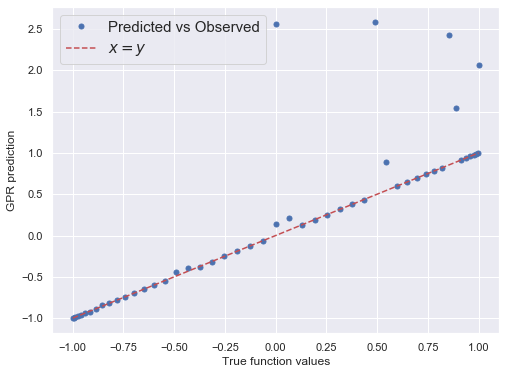

In [21]:
## test the predictions 

# generate some test examples 
Znew = np.linspace(-2, 2, 50)[:, None]
Xnew = np.dot(Znew, Wtrue.T)
Ytrue = f(Xnew)
Wpred = m.kern.A.values 
Zpred = np.dot(Xnew, Wpred)
Ypred = m.predict(Xnew)[0]

# plot
plt.figure(figsize=(8, 6))
plt.plot(Ytrue, Ypred, '.', markersize=10, label='Predicted vs Observed')
_x = np.linspace(np.min(Ytrue), np.max(Ytrue), 50)
plt.plot(_x, _x, 'r--', label='$x=y$')
plt.xlabel('True function values')
plt.ylabel('GPR prediction')
plt.legend(loc='best', fontsize=15)

#### Activity/Questions

+ Experiment with the noise and dataset size and observe how the quality of the predictions change - play around with  the `noise_var` and `N` variables defined above, to do this.

+ Show that the active variable coordinate system has been rescaled, i.e., show that the projection matrix learned by maximizing the GP likelihood is *approximately* a scalar multiple of the true projection matrix. 

+ Can you think of a better way to initialize the projection matrix $\W$? Does it matter? 

## Real world engineering example - HyShot II Scramjet model 

Let's go over a practical example of high-dimensional surrogate modeling in UQ context. We will look at the application discussed [in this paper](https://www.sciencedirect.com/science/article/pii/S002199911500580X?via%3Dihub) by Constantine et al., on quantifying uncertainty in the simulation of a scramjet. 

The goal of the simulations are to characterize reaction flow in a hypersonic scramjet engine. The simulation code takes in 7 input parameters - the *angle of attack*, *turbulence intensity*, *turbulence lengthscale*, *stagnation pressure*, *stagnation enthalpy*, *cowl transition location* and *ramp transition location*. 

The objective of the UQ analysis is to propagate uncertainty in these input parameters to the quantity of interest - the volume average of the pressure over the cylinder end. 

Due to the high computational cost associated with the simulation, the only 16 runs of the simulation could be afforded. To enable Monte Carlo-based uncertainty quantification, the researchers attempt to construct a surrogate that maps the vector of these input parameters to the output quantity of interest with this limited dataset. 

#### Technical summary:

Abstracting away the details of the physical problem, here is the model we wish to learn. We have a dataset $\mathcal{D} = \{  \x^{(i)}, y^{(i)} \}_{i=1}^{16}$, where $\x \in \R^{7}$, and we wish to approximate the map $f:\R^7 \rightarrow \R$ which maps the input parameters to the output quantity of interest. 

In the paper linked above, the authors use the classical formulation of the active subspace (with orthogonal columns). Here we will use our relaxed version of the active subspace and learn a suitable ridge approximation for $f$.

In [22]:
### example

# download some data 
data_url = 'https://raw.githubusercontent.com/paulcon/as-data-sets/master/HyShotII/HyShotII35.txt'
fname = 'data.txt'
if not os.path.exists(fname):
    wget.download(data_url, fname)
data = pd.read_csv(fname)
input_names = data.columns[1:8]
qois = data.columns[8:]
data.head(3)

,Run,AoA,Turb int,Turb len,Stag pres,Stag enth,Cowl trans,Ramp trans,Exit press 0.30,Exit press 0.35
0,1.0,4.085354,1.801645,191.025533,1.745938e+07,3.082492e+06,0.042545,0.177877,2.668523,3.055668
1,2.0,3.826332,0.782859,173.020087,1.860968e+07,3.155262e+06,0.033487,0.089838,2.523197,2.825297
2,3.0,4.155663,1.808725,347.468415,1.700036e+07,3.181476e+06,0.065657,0.140569,2.599225,2.951357


In [23]:
# get X, Y data 
X = data.iloc[:, 1:-2].values
Y = data.iloc[:, -2].values[:, None]
X, Y = shuffle(X, Y)
Xt, Yt, Xtest, Ytest = X[:10], Y[:10], X[10:], Y[10:]

In [24]:
# define kernel 
d = 2
D = X.shape[1]
base_kern = GPy.kern.RBF(d, ARD=True)
k = ProjectionKernel(D, base_kern)
print(k)

  ProjectionKernel.  |   value  |  constraints  |  priors
  A                  |  (7, 2)  |               |        
  rbf.variance       |     1.0  |      +ve      |        
  rbf.lengthscale    |    (2,)  |      +ve      |        


In [25]:
# define a model 
m = GPy.models.GPRegression(X, Y, k)
print(m)


Name : GP regression
Objective : 42.00416257924678
Number of Parameters : 18
Number of Optimization Parameters : 18
Updates : True
Parameters:
  GP_regression.                    |   value  |  constraints  |  priors
  ProjectionKernel.A                |  (7, 2)  |               |        
  ProjectionKernel.rbf.variance     |     1.0  |      +ve      |        
  ProjectionKernel.rbf.lengthscale  |    (2,)  |      +ve      |        
  Gaussian_noise.variance           |     1.0  |      +ve      |        


In [26]:
_ = m.optimize_restarts(20, robust=True)
print(m)

Optimization restart 1/20, f = 36.25176646840934
Optimization restart 2/20, f = 36.25176695079989
Optimization restart 3/20, f = 36.25176695098368
Optimization restart 4/20, f = 36.251766950970186
Optimization restart 5/20, f = 36.25176691892581
Optimization restart 6/20, f = 36.25176695097062
Optimization restart 7/20, f = 36.2517669509704
Optimization restart 8/20, f = 36.25176695097137
Optimization restart 9/20, f = 36.251766950970236
Optimization restart 10/20, f = 36.25176695097018
Optimization restart 11/20, f = 36.251765411497416
Optimization restart 12/20, f = 36.251766931362596
Optimization restart 13/20, f = 36.25176695097022
Optimization restart 14/20, f = 36.251766950970264
Optimization restart 15/20, f = 36.25176695097019
Optimization restart 16/20, f = 36.25176695097335
Optimization restart 17/20, f = 36.251766950970485
Optimization restart 18/20, f = 36.25176695097028
Optimization restart 19/20, f = 36.25176695098297
Optimization restart 20/20, f = 36.251766950970506

Na

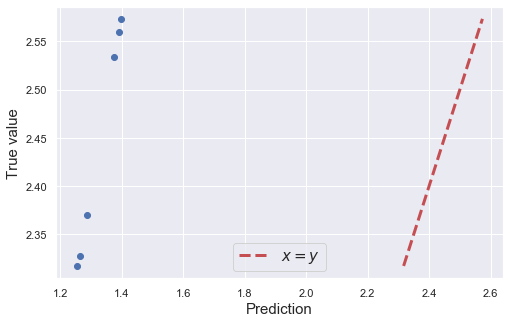

In [27]:
x = np.linspace(np.min(Ytest), np.max(Ytest), 50)
plt.figure(figsize=(8, 5))
plt.plot(x, x, 'r--', label='$x=y$', linewidth=3)
Ypred = m.predict(Xtest)[0]
l2error = np.linalg.norm(Ypred-Ytest)
plt.plot(Ypred, Ytest, '.', markersize=12)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('True value', fontsize=15)
plt.legend(loc='best', fontsize=15)

In [28]:
print(k.base_kernel.lengthscale)

  index  |  GP_regression.ProjectionKernel.rbf.lengthscale  |  constraints  |  priors
  [0]    |                                      0.78540354  |      +ve      |        
  [1]    |                                      0.75751664  |      +ve      |        


#### Questions/Activity

+ Notice above that when we set the dimensionality of the subspace to $d=2$, the lengthscale along the second dimension is much larger relative to the lengthscale along the first dimension. What does this suggest about the structure of $f$?

+ Here, we have handpicked the dimensionality of the active variable. Think of systematic approaches to find the correct $d$.

### High-dimensional model representation (HDMR)

So far, we have discussed *active subspaces* and *ridge function* approximations to deal with the curse of dimensionality in high-dimensional function approximation. We will wrap up this handout with a brief discussion of a different type of structure for high-dimensional functions known as *high dimensional model representation* or HDMR. 

HDMR emerged as a popular technique for data-efficient high-dimensional function approximation in the chemometrics community in the early 2000s. The seminal work on this topic is [this paper](https://www.cs.princeton.edu/picasso/seminarsF04/Li_2001.pdf). 

The core idea behind HDMR is that one can decompose the unknown function $f$ into the following form:
$$
f(\x) = f_0 + \sum_{i=1}^{D} f_i(\x_i) + \sum_{i=1, j>i}^{i,j = D} f_{ij}(\x_i, \x_j) + \dots + f_{12\dots D} (\x),
$$
where,$f_0$ is the mean response of the function, the $f_i$s are univariate functions depending only on the $i^{th}$ components of the input vector $\x$ and capture the contribution of individual input directions to the variance of $f$, the $f_{ij}$s depend only on $i$th and $j$th components of $\x$ and capture 2nd order interaction effects between all possible pairs of input directions, and so on. 

The classical formulation of HDMR imposes 2 further constraints on the component functions $f_i$s, $f_ij$s etc.:

1. The individual component functions should integrate to zero over the domain of interest, i.e.,  $\int f_{i_1 i_2 \dots i_k} (\x_{i_1}, \x_{i_2}, \dots, \x_{i_k}) \mathrm{d}\x_{i_1} \mathrm{d}\x_{i_2} \dots \mathrm{d}\x_{i_k} = 0$ for any combination of $k$ directions $(i_1, i_2, \dots, i_k)$, with $k \le D$.

2. The component functions $f_i$s, $f_{ij}$s etc. are mutually orthogonal,i.e., given 2 sets of component function indices $s_1 = \{i_1, i_2, \dots, i_{k_1} \}$ and $s_2 = \{ i_1, i_2, \dots, i_{k_2} \}$, $k_1, k_2 \le D$, the component functions, $f_{s_1}$ and $f_{s_2}$ satisfy:
$$
\int f_{s_1}(\x) f_{s_2} (\x) \mathrm{d}\x = \delta_{s_1 s_2},
$$
where $\delta_{s_1 s_2}$ is the Kronecker delta function which is 1 if all components in the index set $s_1$ and $s_2$ match and zero otherwise. 

Constraints (1) and (2) lead to a neat intepretation of the HDMR structure - the variance of the function $f$ decomposes into the sum of the variances of the individual component functions, i.e., if $\mathbb{V}[f(\x)] = \sigma^{2}$, then:
$$
\sigma^{2} = \sum_{i=1}^{D} \sigma_{i}^{2} + \sum_{i=1,j > i}^{i, j = D} \sigma_{ij}^{2} + \dots 
$$

This is straightforward to prove and we leave it as an exercise to the reader.

Practical applications of the HDMR approach to high-dimensional function approximation have shown to exhibit fast convergence, typically requiring HDMR expansions capturing upto 2nd order interaction effects.

### High-dimensional model representation (HDMR) with Gaussian processes

We will leverage the additive structure of HDMR and use learn it through Gaussian processes. In doing so, we will relax the constraints (1) and (2) and simply learn a generalized HDMR structure.
What this means is that we want to train our model to learn a function that possess the following structure:
$$
f(\x) = f_0 + \sum_{i=1}^{D} f_i (\x_i) + \sum_{i=1,j>i}^{i, j = D} f_{ij} (\x_i, \y_j)
$$

Note that we will restrict ourselves to 2nd order interaction effects. As our example function, we will use the modified 3 dimensional Barnin-Hoo function defined earlier in the handout. 

In [29]:
# Define the function
def f_branin_1(x):
    """
    Input must be 2D array of size N x 2.
    """
    return (1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)) + (0.1*x[:, 2])

To learn function that have the HDMR structure, we need to place a prior over the space of all such functions. To do this, we simply define our covariance kernel as follows:
$$
k(\x, \x') = \sum_{i=1}^{D} k_i (\x_i, \x_{i}^{'}) + \sum_{i=1, j>i}^{i, j = D} k_{ij}(\x_{ij}, \x_{ij}^{'}).
$$

We further decompose the kernel acting on the input pairs $\x_i$ and $\x_j$ as the product of the base kernels in the $i$ and $j$ directions, i.e., $k_{ij}(\x_{ij}, \x_{ij}^{'}) = k_i(\x_i, \x_{i}^{'}) k_i(\x_j, \x_{j}^{'})$. 

This is easy to accomplish practically. All need to do is to define a set of kernels for each component direction, i.e., the $k_i$s and add and multiply them appropriately. 

In [30]:
# define base kernels 
D = 3
k_is = [GPy.kern.RBF(1, active_dims=[i]) for i in range(D)]
#for k in k_is:
#    k.variance.constrain_fixed()

# define the kernel for first order effects 
k_first = GPy.kern.src.add.Add(k_is)

# define the 2nd order interaction component kernels
k_seconds = [k_is[i] * k_is[j] for i in range(D) for j in range(i+1, D)]
k_second = GPy.kern.src.add.Add(k_seconds)

Now let's generate some data and train the model.

In [31]:
# Generate synthetic data
N    = 40
X = pyDOE.lhs(D, N)

# We will also be adding a little bit of noise to the observations
sigma = 0.01
Y = f_branin_1(X)[:, None] + sigma * np.random.randn(N, 1)

k = k_first + k_second
gp = GPy.models.GPRegression(X, Y, k)
_ = gp.optimize_restarts(20, robust=True)

Optimization restart 1/20, f = -39.986921605592244
Optimization restart 2/20, f = -41.01313971634744
Optimization restart 3/20, f = -39.98653345967385
Optimization restart 4/20, f = -38.38882874535473
Optimization restart 5/20, f = -40.41110125665799
Optimization restart 6/20, f = -39.98792115893576
Optimization restart 7/20, f = -39.98722790624339
Optimization restart 8/20, f = -39.171156735971294
Optimization restart 9/20, f = -39.98776907212911
Optimization restart 10/20, f = -38.388824646919076
Optimization restart 11/20, f = -38.38883033074546
Optimization restart 12/20, f = -38.38820498128965
Optimization restart 13/20, f = -38.388757982047764
Optimization restart 14/20, f = -38.38882266719516
Optimization restart 15/20, f = -38.38880114603798
Optimization restart 16/20, f = -39.12511597711324
Optimization restart 17/20, f = -38.38882007086589
Optimization restart 18/20, f = -38.03181718069196
Optimization restart 19/20, f = -38.388828845589885
Optimization restart 20/20, f = -39

Let's test the predictions from this model.

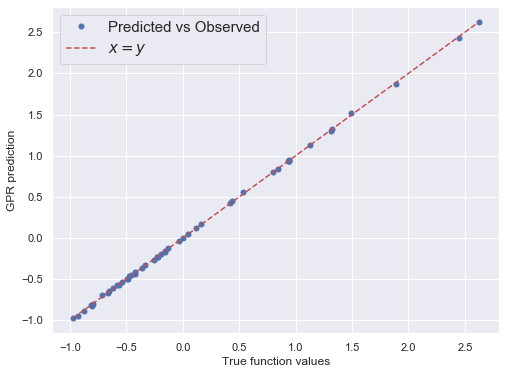

In [32]:
# Generate some test data
Ntest    = 50
Xtest = pyDOE.lhs(D, Ntest)
Ytrue = f_branin_1(Xtest)[:, None]
Ypred = gp.predict(Xtest)[0]

# plot
plt.figure(figsize=(8, 6))
plt.plot(Ytrue, Ypred, '.', markersize=10, label='Predicted vs Observed')
_x = np.linspace(np.min(Ytrue), np.max(Ytrue), 50)
plt.plot(_x, _x, 'r--', label='$x=y$')
plt.xlabel('True function values')
plt.ylabel('GPR prediction')
plt.legend(loc='best', fontsize=15)

#### Questions/Activity

In the above example, we showed you how to fit functions that possess the HDMR structure and applied to the 3 dimensional Branin-Hoo example. What happens if you only consider 1st order effects for this same problem? What happens if you include 3rd order effects?